<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/5_PPO/5_2_PPO_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPO

In [1]:
import gym
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from gym import spaces

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Wrapper

In [4]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [5]:

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

In [7]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

In [9]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

In [10]:
def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

In [11]:
def wrap_deepmind(env, episode_life=True, clip_rewards=True):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    env = WarpFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    return env

In [12]:
def wrap_pytorch(env):
    return ImageToPyTorch(env)

# Replay Buffer

In [13]:
class ReplayBuffer:
    """
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    with some modifications
    """
    def __init__(self, obs_shape, act_shape, buffer_size):
        buffer_obs_shape = tuple([buffer_size]) + obs_shape
        buffer_act_shape = tuple([buffer_size]) + act_shape
        self.obs_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.act_buf = np.zeros(buffer_act_shape, dtype=np.float32)
        self.ret_buf = np.zeros(buffer_size, dtype=np.float32)
        self.adv_buf = np.zeros(buffer_size, dtype=np.float32)
        self.prob_old_buf = np.zeros(buffer_size, dtype=np.float32)
        self.pointer, self.size, self.buffer_size = 0, 0, buffer_size

    def store(self, obs, act, ret, adv, prob_old):
        self.obs_buf[self.pointer] = obs
        self.act_buf[self.pointer] = act
        self.ret_buf[self.pointer] = ret
        self.adv_buf[self.pointer] = adv
        self.prob_old_buf[self.pointer] = prob_old
        self.pointer = (self.pointer+1) % self.buffer_size
        self.size = min(self.size+1, self.buffer_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     act=self.act_buf[idxs],
                     ret=self.ret_buf[idxs],
                     adv=self.adv_buf[idxs],
                     prob_old=self.prob_old_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def __len__(self):
        return self.size

# Policy & value function

In [14]:
class PongPolicy(nn.Module):
    def __init__(self, channel_dim, n_actions, device):
        super(PongPolicy, self).__init__()

        self.channel_dim = channel_dim
        self.n_actions = n_actions
        self.device = device

        self.c1 = nn.Conv2d(channel_dim, 32, kernel_size=8, stride=4)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.c3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.l1 = nn.Linear(3136, 512)
        self.l2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x, dim=-1)

        return x

    def get_action_prob(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = torch.unsqueeze(obs, 0) # (1, 84, 84) -> (1, 1, 84, 84)
        obs = obs.to(self.device)
        output = self.forward(obs)
        categorical = Categorical(output)
        action = categorical.sample()
        # logprob = categorical.log_prob(action)
        prob = output.squeeze()[action]

        return action.item(), prob

In [15]:
class PongCritic(nn.Module):
    def __init__(self, channel_dim, device):
        super(PongCritic, self).__init__()

        self.channel_dim = channel_dim
        self.device = device

        self.c1 = nn.Conv2d(channel_dim, 32, kernel_size=8, stride=4)
        self.c2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.c3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.l1 = nn.Linear(3136, 512)
        self.l2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = self.l2(x)

        return x
    
    def get_value(self, obs):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = torch.unsqueeze(obs, 0) # (1, 84, 84) -> (1, 1, 84, 84)
        obs = obs.to(self.device)
        output = self.forward(obs)

        return output

# Train

In [16]:
def train_pi(pi, batch, pi_optimizer, gamma, epsilon, device):
    pi.train()

    obs = batch["obs"].to(device) # (batch, 4)
    act = torch.tensor(batch["act"], dtype=torch.int64).to(device) # (batch, 1)
    adv = batch["adv"].to(device) # (batch)
    prob_old = batch["prob_old"].to(device) # (batch)

    pi_output = pi(obs)
    prob = torch.gather(pi_output, 1, act).squeeze(1) # (batch)
    
    ratio = prob / prob_old # (batch)
    l1 = ratio * adv # (batch)
    l2 = torch.clip(input=ratio, min=1-epsilon, max=1+epsilon) * adv # (batch)
    l_clip = -(torch.min(l1, l2)).mean()

    pi_optimizer.zero_grad()
    l_clip.backward()
    pi_optimizer.step()


In [17]:
def train_v(v, batch, v_optimizer, device):
    v.train()

    obs = batch["obs"].to(device) # (batch, 4)
    ret = batch["ret"].to(device) # (batch)

    v_output = v(obs).squeeze(1)
    v_loss = (v_output - ret).pow(2).mean()

    v_optimizer.zero_grad()
    v_loss.backward()
    v_optimizer.step()


# Plot

In [18]:
def plot(rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    # plt.title('')
    plt.ylabel('reward')
    plt.xlabel('episode')
    plt.plot(rewards)
    plt.show()

# Main

In [19]:
# Save device (cpu or cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
env = make_atari("PongNoFrameskip-v4")
env = wrap_deepmind(env)
env = wrap_pytorch(env)

# shape
obs_shape = env.observation_space.shape # (1, 84, 84)
act_shape = tuple([1]) # int to Tuple
channel_dim = obs_shape[0] # 1
n_actions = env.action_space.n # 6
buffer_size = 200000

# Define NN
pi = PongPolicy(channel_dim=channel_dim, n_actions=n_actions, device=device)
v  = PongCritic(channel_dim=channel_dim, device=device)
pi.to(device)
v.to(device)

# Biffer & Optimizer
replay_buffer = ReplayBuffer(obs_shape, act_shape, buffer_size)
pi_optimizer = optim.Adam(pi.parameters(), lr=0.00001)
v_optimizer = optim.Adam(v.parameters(), lr=0.00001)

# training parameters
total_iteration = 30000
N = 1 # number of Actors, but here 1. No multiprocessing on this implementation.
batch_size = 256 * N
T = 128
gamma = 0.99
epsilon = 0.2
K = 30 # Num. epochs

# list for saving results
rewards = []

# temperal buffer
obs_list = []
act_list = []
ret_list = []
prob_old_list = []
adv_list = []

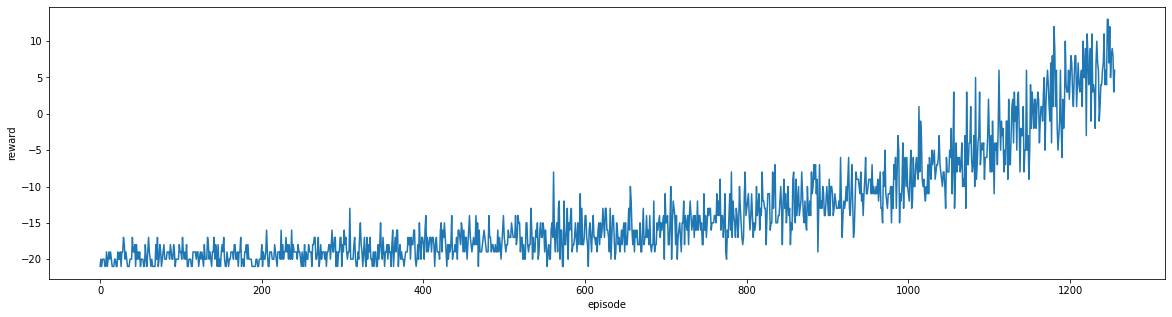

17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273


In [ ]:
episode_reward = 0
best_reward = -999999
obs = env.reset()
for i in range(total_iteration):
    # Run policy pi_old in environment for T timesteps
    for t in range(T):
        with torch.no_grad(): # prob_old doesn't require any gradients
            action, prob = pi.get_action_prob(obs)
        next_obs, rew, done, _ = env.step(action)
        episode_reward += rew
        obs_list.append(obs)
        act_list.append(action)
        ret_list.append(rew)
        prob_old_list.append(prob.item())
        obs = next_obs
        
        if done:
            # Save the best model
            if best_reward <= episode_reward:
                best_reward = episode_reward
                torch.save(pi.state_dict(), "pi.pt")
            rewards.append(episode_reward)
            plot(rewards)
            obs_list.append(obs) # For getting V(S_T)
            obs = env.reset()
            episode_reward = 0
            break
    
    # Compute advantage estimates A_1 ... A_T
    for j in range(len(ret_list)-2, -1, -1): # reverse
        ret_list[j] += ret_list[j+1]*gamma
    Vs_T = v.get_value(obs_list[-1]).item()
    for t in range(len(ret_list)):
        Vs_t = v.get_value(obs_list[t]).item()
        adv = -Vs_t + ret_list[t] + gamma**(len(ret_list)-t)*Vs_T
        adv_list.append(adv)
    
    # Save to main buffer & clear out temp buffer
    for j in range(len(ret_list)):
        replay_buffer.store(obs_list[j], act_list[j], ret_list[j], adv_list[j],
                            prob_old_list[j])
    obs_list = []
    act_list = []
    ret_list = []
    prob_old_list = []
    adv_list = []

    # train pi with surrogate L_clip w.r.t. \theta,
    # with K epochs and minibatch size M <= NT
    if len(replay_buffer) > batch_size:
        for _ in range(K):
            # Train pi & v
            sampled_batch = replay_buffer.sample_batch(batch_size=batch_size)
            train_pi(pi, sampled_batch, pi_optimizer, gamma, epsilon, device)
            train_v(v, sampled_batch, v_optimizer, device)

# Render

In [ ]:
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper

In [ ]:
import gnwrapper
import gym

env = make_atari("PongNoFrameskip-v4")
env = wrap_deepmind(env)
env = wrap_pytorch(env)
env = gnwrapper.LoopAnimation(env)

obs = env.reset()
for _ in range(500):
    obs, rew, done, _ = env.step(env.action_space.sample()) # Take random action
    env.render()
    if done:
        obs = env.reset()

env.display()

In [ ]:
pi.load_state_dict(torch.load("pi.pt"))

env = make_atari("PongNoFrameskip-v4")
env = wrap_deepmind(env)
env = wrap_pytorch(env)
env = gnwrapper.LoopAnimation(env)

obs = env.reset()
for _ in range(500):
    action, _ = pi.get_action_prob(obs)  # Take action from trained model
    env.render()
    obs, rew, done, _ = env.step(action)
    if done:
        obs = env.reset()

env.display()